## Problem 1 
<br> 
<p>Implement Shelling's (1969) model on a 2-D grid as discussed in the lecture. Specifically, compare the overall segregation between the case when the threshold is .35 and the case when the threshold is .65. To do this, carry out at least 1000 simulations to obtain the average evolution of the segregation measure for each case and plot two lines on the same graph to make the comparison clear. (Consider 10x10 grid to start)<p>

In [20]:
import numpy as np
import re

In [21]:
def check_proportion(neighborhood,ownRace):
    # input: neighborhood is an array, ownRace is a number 
    # output: proportion of neighbors of the same race
    return np.mean(neighborhood==ownRace)

In [22]:
def get_neighborhood(grid, i):
    neighbors = []
    # define the location and neighbors for the corners, edges, and inners in grid
    corners = {
        r"^0$": [1, 10, 11],  # top-left corner
        r"^9$": [8, 18, 19],  # top-right corner
        r"^90$": [80, 81, 91],  # bottom-left corner
        r"^99$": [88, 89, 98],  # bottom-right corner
    }
    edges = {
        r"^[1-8]$": [-1, 1, 9, 10, 11],  # top edge (excluding corners)
        r"^[1-9]0$": [-10, -9, 1, 10, 11],  # left edge (excluding corners)
        r"^[1-9]9$": [-11, -10, -1, 9, 10],  # right edge (excluding corners)
        r"^9[1-8]$": [-11, -10, -9, -1, 1],  # bottom edge (excluding corners)
    }
    inners = [-11, -10, -9, -1, 1, 9, 10, 11]

    for pattern, offsets in corners.items():
        if re.match(pattern, str(i)):
            neighbors = offsets
            break
    else:
        for pattern, offsets in edges.items():
            if re.match(pattern, str(i)):
                neighbors = [i + offset for offset in offsets]
                break
        else:
            neighbors = [i + offset for offset in inners]

    hood = np.array([grid[n] for n in neighbors])
    return hood

In [23]:
class Agent:
    # class definition of the Agent
    
    def __init__(self,location,race,neighbors,threshold):
        # Initialize agent.
        # location -- location of the agent
        # race -- race of the agent
        # neighborhood -- list of neighbors
        # threshold -- similarity threshold

        self.loc = location
        self.race = race
        self.neighborhood = neighbors
        self.thresh = threshold
        
        
    def satisfied(self): 
        # function that returns True of False depending if the threshold is met
        return check_proportion(self.neighborhood,self.race)>=self.thresh
    
    
    def segMetric(self):
        # function that returns the proportion of neighbors of the same race 
        return check_proportion(self.neighborhood,self.race)
    
    
    def moveToNewLoc(self,newLoc,newNeighbors): 
        # function that updates the new neighborhood info
        self.loc=newLoc
        self.neighborhood=copy.deepcopy(newNeighbors)
    
    
    def __repr__(self):
        return "Location:"+str(self.loc)+" Race:"+str(self.race)+" Neighbors:"+str(self.neighborhood)
    
    
    def __str__(self):
        return "L"+str(self.loc)

In [24]:
import copy

In [25]:
class Environment:
    # class definition of the Environment
    
    def __init__(self, races, props, threshold, width=10, length=10, max_iter=1000):
        # initialize environment.
        # races -- array of races (e.g., [0,1,2]) with 0 denoting an empty space
        # props -- proportion of races
        # threshold -- similarity threshold
        # width -- width of the grid
        # length -- length of the grid
        # max_iter -- maximum number of iterations
        
        self.width = width
        self.length = length
        self.races = races
        self.props = props        
        self.threshold = threshold
        self.max_iter = max_iter
        
        self.agents = []
        self.grid = []
        self.two_d = []
        self.available_locs=[]
        self.all_satisfied=False
        
        
    def resetLine(self):
        self.grid=np.zeros(self.width*self.length)
        self.available_locs=range(self.width*self.length)
        for i in self.races[1:]:
            locs=np.random.choice(self.available_locs,size=int(self.props[i]*self.width*self.length),replace=False)
            self.grid[locs]=self.races[i]
            self.available_locs=np.setdiff1d(self.available_locs,locs)
           
        self.agents = []
        for i,r in enumerate(self.grid):
            if r>0:
                hood=get_neighborhood(self.grid,i)
                self.agents.append(Agent(i,r,hood,self.threshold))
                
    
    def oneMoveEach(self):
        self.all_satisfied = True # set it to true, if encounter anyone that is not satisfied then set it to false
        for a in self.agents:
            
            if not a.satisfied():
                self.all_satisfied = False
                oldLoc=a.loc
                newLoc=np.random.choice(self.available_locs,size=1)[0]
                
                self.grid[oldLoc]=0
                self.grid[newLoc]=a.race
                self.available_locs=np.setdiff1d(self.available_locs,newLoc)
                
                newHood=get_neighborhood(self.grid,newLoc)
                a.moveToNewLoc(newLoc,newHood)
                self.available_locs=np.append(self.available_locs,np.array([oldLoc]),axis=0)
            
    
    def runUntilConverged(self):
        res = []
        seg = []
        step=0
        sim=[]
        while not self.all_satisfied and step<=self.max_iter:
            sim.append(step)
            for a in self.agents:
                res.append(a.segMetric())
            seg.append(np.mean(res))
            self.oneMoveEach()
            step=step + 1
        return np.array(sim), np.array(seg)

       
    def __str__(self):
        array=np.array(self.grid)
        self.two_d=array.reshape((self.width,self.length))
        return str(self.two_d)

In [26]:
E_65=Environment(np.array([0,1,2]), np.array([.100,.675,.225]), .65)
E_35=Environment(np.array([0,1,2]), np.array([.100,.675,.225]), .35)
E_65.resetLine()
E_35.resetLine()
print(E_35)
print(E_65)

[[1. 1. 1. 2. 1. 2. 2. 1. 1. 1.]
 [2. 2. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 1. 0. 2. 1. 1. 1.]
 [1. 2. 1. 2. 0. 2. 1. 1. 1. 0.]
 [1. 2. 1. 1. 2. 1. 1. 1. 1. 1.]
 [0. 1. 1. 2. 1. 2. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 2. 1. 1. 2. 0.]
 [1. 1. 1. 1. 2. 1. 2. 2. 1. 1.]
 [1. 1. 2. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 2. 1. 2. 1. 1. 1.]]
[[2. 1. 1. 2. 1. 1. 1. 1. 2. 2.]
 [0. 2. 2. 1. 1. 1. 0. 1. 1. 2.]
 [2. 2. 1. 2. 2. 2. 1. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 2. 1. 1. 1. 1. 2. 1.]
 [1. 1. 1. 1. 1. 2. 1. 1. 1. 2.]
 [1. 1. 1. 1. 2. 2. 2. 1. 1. 1.]
 [1. 2. 0. 1. 1. 0. 1. 1. 2. 1.]
 [1. 1. 1. 1. 2. 0. 1. 1. 1. 1.]]


In [27]:
E_35.oneMoveEach()
E_65.oneMoveEach()

In [28]:
print(E_35)
print(E_65)

[[0. 1. 1. 2. 1. 2. 0. 1. 1. 1.]
 [2. 2. 1. 1. 1. 1. 2. 1. 1. 1.]
 [2. 2. 1. 2. 1. 1. 2. 1. 1. 1.]
 [1. 0. 1. 2. 0. 2. 1. 1. 1. 0.]
 [1. 2. 1. 1. 2. 1. 1. 1. 1. 1.]
 [2. 1. 1. 2. 1. 2. 1. 1. 1. 1.]
 [2. 1. 1. 2. 1. 2. 1. 1. 0. 2.]
 [1. 1. 1. 1. 2. 1. 0. 0. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 0. 1. 0. 1. 1. 1.]]
[[1. 2. 2. 1. 1. 1. 1. 2. 1. 2.]
 [1. 2. 1. 0. 1. 2. 1. 2. 1. 1.]
 [1. 1. 2. 1. 2. 2. 1. 1. 2. 1.]
 [2. 1. 2. 1. 1. 1. 2. 1. 1. 1.]
 [1. 2. 2. 1. 1. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 0. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 1. 2. 1. 1. 1. 2.]
 [1. 2. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 1.]]


In [29]:
sim_65, reg_65 = E_65.runUntilConverged()
sim_35, reg_35 = E_35.runUntilConverged()

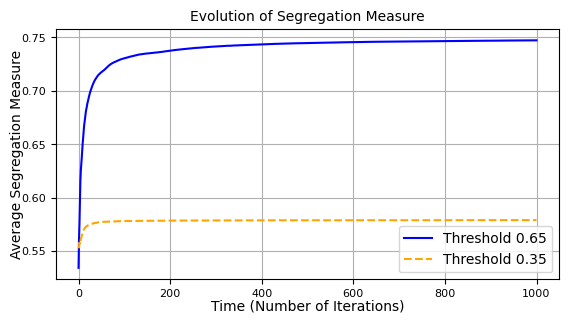

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5, 3.25))
plt.plot(sim_65, reg_65, label='Threshold 0.65', color='blue')
plt.plot(sim_35, reg_35, label='Threshold 0.35', color='orange', linestyle='--')
plt.xlabel('Time (Number of Iterations)', fontsize=10, va='center_baseline')
plt.ylabel('Average Segregation Measure', fontsize=10, va='center_baseline')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('Evolution of Segregation Measure', fontsize=10)
plt.legend(fontsize=10, loc='best')
plt.grid(True)
plt.savefig('Evolution of Segregation Measure.png')
plt.show()

## Problem 2
<br>
<p>Replicate the first two rows of Figure 1 and the first two rows of Column 1 of Table 2 in Gode & Sunder (1993)<p>

In [31]:
class Buyer:
    # 6 Buyer has 36 goods plan to buy. We can number each good and 
    # set each of them a reservation value, above which it will not be traded

    def __init__(self, maxValue):
        self.Value = 0
        self.Traded = 0 # record whether a good traded or not

    
    def formBidPrice(self, constrained, predictedPrice, maxValue):
    # generate a bid offer depending if the simulation runs with or without a constraint
        if constrained == 1:
            potentialBid = self.Value - (np.random.rand() * (self.Value - 1))
            bid = potentialBid
        else:
            potentialBid = np.random.rand() * (maxValue - 1)
            bid = potentialBid
        return bid

In [32]:
class Seller:
    # 6 Sellers has 36 goods plan to buy. We can number each good and 
    # set each of them a reservation value, below which it will not be traded

    def __init__(self, maxCost):
        self.Cost = 0
        self.Traded = 0


    def formAskPrice(self, constrained, predictedPrice, maxValue, maxCost):
    # generate an ask offer depending if the simulation runs with or without a constraint
        if constrained == 1:
            potentialAsk = self.Cost + ((np.random.rand() * np.absolute(maxValue - self.Cost)))
            ask = potentialAsk
        else:
            potentialAsk = np.random.rand() * (maxCost - 1)
            ask = potentialAsk
        return ask

In [33]:
def initializeBook(maxCost):
    # initialize order book variables. Record the best standing bid and ask,
    # the ID of the best bidders (index number in buyer/seller vectors),
    # transaction price (initialized to 0) and logical variables to determine
    # if there currently is a standing bid or ask. Initially there are no best
    # bidders, so index of each is 0. The order book vector also records the
    # added value of a given trade (initialized to 0)

    # First index is the best bid (initialized to 0)
    # Second index is the best bid ID (initialized to 0, nobody)
    # Third index is the logical variable for current bid (1 for true, initialized to 0)
    # Fourth index is the best ask (initialized to the max cost for sellers)
    # Fifth index is the best ask ID (initialized to 0, nobody)
    # Sixth index is the logical variable for current ask (1 for true, initialized to 0).
    # Seventh index is the transaction price (initialized to 0)
    # Eight index is surplus added from a given trade (initially 0, no trade)

    orderBookValues = [0, 0, 0, maxCost, 0, 0, 0, 0]
    return orderBookValues

In [34]:
def doTrade(buyers, sellers, bookValues, numberTraders, predictedPrice, constrained, maxValue, maxCost):
    # operates the double auction order book. The function
    # determines with 50% probability whether the next trader to submit an
    # offer is a buyer or a seller. Then, it compares the new bid/ask and
    # executes a trade if it satisfies the counterposing best standing offer,
    # or it takes the place as best offer of its kind if it is better than the
    # currently standing one (for example, if a new bid is submitted and it is
    # higher than the best ask, a trade will occur, but if it's not higher than
    # the best ask but higher than the best standing bid it will take its
    # place. A similar process takes place if a seller submits an ask). The
    # function returns an updated state of the order book to update simulation.

    # initialize return vector to current book values
    updatedValues = bookValues

    # randomly choose between a buyer and a seller (below 0.5 we select a
    # buyer, otherwise we select a seller).
    traderDeterminer = np.random.rand()

    # process as buyer
    if traderDeterminer < 0.5:

        # Initialize a new buyer (good) ID (at first 0)
        newBuyer = -1

        # choose a random buyer that has yet not traded,
        # lock selection of a buyer in a while loop 
        # until it chooses a buyer that hasn't traded
        while newBuyer == -1:
            # Choose a random index in the buyers vector to select a buyer
            randomIndex = np.random.randint(0, numberTraders)
            if buyers[randomIndex].Traded == 0:
                newBuyer = randomIndex

        # make buyer generate a random bid based on its reservation price and
        # simulation constraint
        newBid = buyers[newBuyer].formBidPrice(constrained, predictedPrice, maxValue)

        # do a trade if there is currently a standing ask that the bid can
        # trade with. Check the logical variable and the value of the best
        # standing ask
        if (updatedValues[5] == 1) & (newBid > updatedValues[3]):
            # set the transaction price to the best ask value
            updatedValues[6] = updatedValues[3]
            # record surplus added by the trade
            updatedValues[7] = buyers[newBuyer].Value - sellers[updatedValues[4]].Cost
            # update ID of buyer (good)
            updatedValues[1] = newBuyer

        # if the there is no trade, set the bid as best bid if it is higher
        # than the currently standing best bid, even if it doesn't satisfy the
        # ask or if there currently is no ask
        else:
            if newBid > updatedValues[0]:
                # set new bid as best bid, and update the ID of bidder
                updatedValues[0] = newBid
                updatedValues[1] = newBuyer
                # set logical variable for standing bid to true
                updatedValues[2] = 1
                # if new bid is lower than best bid, do nothing
    # process a seller
    else:
        # initialize a new seller (good) ID (at first 0)
        newSeller = -1
        # choose a random seller that has yet not traded, 
        # lock selection of a seller in a while loop
        #  until it chooses a seller that hasn't traded
        while newSeller == -1:
            # choose a random index in the sellers vector to select a seller
            randomIndex = np.random.randint(0, numberTraders)
            if sellers[randomIndex].Traded == 0:
                newSeller = randomIndex

        # make seller generate a random ask based on its reservation cost and
        # simulation constraint
        newAsk = sellers[newSeller].formAskPrice(constrained, predictedPrice, maxValue, maxCost)

        # ddo a trade if there is currently a standing bid that the ask can
        # trade with. Check the logical variable and the value of the best
        # standing bid
        if (updatedValues[2] == 1) & (updatedValues[0] > newAsk):
            # set the transaction price to the best bid value
            updatedValues[6] = updatedValues[0]
            # record surplus added by the trade
            updatedValues[7] = buyers[updatedValues[1]].Value - sellers[newSeller].Cost
            # record ID of seller
            updatedValues[4] = newSeller
        # if the there is no trade, set the ask as best ask if it is lower
        # than the currently standing best ask, even if it doesn't satisfy the
        # bid or if there currently is no bid
        else:
            if newAsk < updatedValues[3]:
                # set new ask as best ask, and update the ID of bidder
                updatedValues[3] = newAsk
                updatedValues[4] = newSeller
                # set logical variable for standing ask to true
                updatedValues[5] = 1
                # if new ask is higher than best ask, do nothing

    return updatedValues

In [35]:
import matplotlib.pyplot as plt

numberTraders = 36 

refresh = True

maxValue = 200 
maxCost = 200

round = 6
iterations = 3000

# initialize all buyers to not traded state and 
# give a reservation value to each good
buyers = []    
for i in range(numberTraders):
    buyers.append(Buyer(maxValue))
    
valueVec = [100] * 6 + [95] * 6 + [90] * 6 + [85] * 6 + [80] * 6 + [75] * 6
for i in range(numberTraders):
    buyers[i].Value = valueVec[i]
    buyers[i].Traded = 0

# initialize all buyers to not traded state and 
# give a reservation value to each good
sellers = []
for i in range(numberTraders):
    sellers.append(Seller(maxCost))
    
costVec = [40] * 6 + [50] * 6 + [60] * 6 + [70] * 6 + [80] * 6 + [90] * 6
for i in range(numberTraders):
    sellers[i].Cost = costVec[i]
    sellers[i].Traded = 0

    
# sort values to calculate equilibrium values and to 
# later plot demand and supply curves
# given unconstrained condition
buyerValues_0 = []
for i in range(numberTraders):
    buyerValues_0.append(buyers[i].Value)
buyerValues_0.sort(reverse = True)

sellerCosts_0 = []
for i in range(numberTraders):
    sellerCosts_0.append(sellers[i].Cost)
sellerCosts_0.sort()
    
# compute theoretical equilibrium
predictedPrice = 0
predictedQuantity = 0

for i in range(numberTraders):
    # if value of buyer is greater than cost of seller, there is a trade.
    # Then, quantity increases by one, there are gains for trade (surplus)
    # and the price is updated
    if (buyerValues_0[i] - sellerCosts_0[i]) > 0:
        predictedPrice = (buyerValues_0[i] + sellerCosts_0[i]) /2
        predictedQuantity = predictedQuantity + 1
        
# initialize the order book vector
orderBookValues = initializeBook(maxCost)

# initialize vector with transaction prices (update as iterations execute)
# let the length of the vector be the maximum number of iterations, then
# discard leftover indexes initialized to zero
alltp_0 = []
transactionPrices_0 = []

# initial surplus is 0
surplus_0 = 0

# initial quantity traded is 0
quantity = 0

tradedValues = []
tradedCosts  = []

for r in range(round):
    for i in range(iterations):
    # stop the loop if all buyers and sellers have already traded. Note
    # that if all buyers have traded, all sellers have traded, since each
    # trader is allowed to trade only once
        if sum(buyers.Traded for buyers in buyers) == numberTraders:
            break
    
        # attempt a trade or a new bid/ask (report update if trade occurs)
        orderBookValues = doTrade(buyers, sellers, orderBookValues, numberTraders, predictedPrice, 0, maxValue, maxCost)
    
        # record transaction price, update surplus and quantity, mark traders 
        # to record that they have traded, and reinitialize the order book
        # if a trade occured
        if orderBookValues[6] > 0:
            transactionPrices_0.append(orderBookValues[6])
            surplus_0 = surplus_0 + orderBookValues[7]
            buyers[orderBookValues[1]].Traded = 1
            sellers[orderBookValues[4]].Traded = 1
            tradedValues.append(buyers[orderBookValues[1]].Value)
            tradedCosts.append(sellers[orderBookValues[4]].Cost)
            orderBookValues = initializeBook(maxCost)
            quantity = quantity +1
    alltp_0.extend(transactionPrices_0)    
            # if refresh is True, then redraw values for all buyers and sellers
            # this makes this as if at start with a complete refresh
    if refresh:
        for checkBuyer in buyers:
            if(checkBuyer.Traded == 0):
                checkBuyer.Value = valueVec[np.random.randint(numberTraders)]
        for checkSeller in sellers:
            if(checkSeller.Traded == 0):
                checkSeller.Cost = costVec[np.random.randint(numberTraders)]

# calculate simulation surplus as percentage of total possible surplus
    if refresh:
        tradedValnp = np.array(tradedValues)
        tradedCostnp = np.array(tradedCosts)
        tradedValnp = np.sort(tradedValnp)[::-1]
        tradedCostnp.sort()
        infraMarginal = (tradedValnp>tradedCostnp)
        maximumSurplus_0 = np.sum(tradedValnp[infraMarginal]-tradedCostnp[infraMarginal])

surplusPercentage_0 = surplus_0 / maximumSurplus_0 * 100.
SimulationPrice = np.mean(transactionPrices_0[-50:])

In [36]:
buyers = []    
for i in range(numberTraders):
    buyers.append(Buyer(maxValue))
    
valueVec = [100] * 6 + [95] * 6 + [90] * 6 + [85] * 6 + [80] * 6 + [75] * 6
for i in range(numberTraders):
    buyers[i].Value = valueVec[i]
    buyers[i].Traded = 0

sellers = []
for i in range(numberTraders):
    sellers.append(Seller(maxCost))
    
costVec = [40] * 6 + [50] * 6 + [60] * 6 + [70] * 6 + [80] * 6 + [90] * 6
for i in range(numberTraders):
    sellers[i].Cost = costVec[i]
    sellers[i].Traded = 0

buyerValues_1 = []
for i in range(numberTraders):
    buyerValues_1.append(buyers[i].Value)
buyerValues_1.sort(reverse = True)

sellerCosts_1 = []
for i in range(numberTraders):
    sellerCosts_1.append(sellers[i].Cost)
sellerCosts_1.sort()
    
# compute theoretical equilibrium
predictedPrice = 0
predictedQuantity = 0

for i in range(numberTraders):
    if (buyerValues_0[i] - sellerCosts_0[i]) > 0:
        predictedPrice = (buyerValues_0[i] + sellerCosts_0[i]) /2
        predictedQuantity = predictedQuantity + 1
        
orderBookValues = initializeBook(maxCost)

alltp_1 = []
transactionPrices_1 = []

surplus_1 = 0

quantity = 0

tradedValues = []
tradedCosts  = []

for r in range(round):
    for i in range(iterations):
        if sum(buyers.Traded for buyers in buyers) == numberTraders:
            break
    
        orderBookValues = doTrade(buyers, sellers, orderBookValues, numberTraders, predictedPrice, 1, maxValue, maxCost)
    
        if orderBookValues[6] > 0:
            transactionPrices_1.append(orderBookValues[6])
            surplus_1 = surplus_1 + orderBookValues[7]
            buyers[orderBookValues[1]].Traded = 1
            sellers[orderBookValues[4]].Traded = 1
            tradedValues.append(buyers[orderBookValues[1]].Value)
            tradedCosts.append(sellers[orderBookValues[4]].Cost)
            orderBookValues = initializeBook(maxCost)
            quantity = quantity +1
    alltp_1.extend(transactionPrices_1)    

    if refresh:
        for checkBuyer in buyers:
            if(checkBuyer.Traded == 0):
                checkBuyer.Value = valueVec[np.random.randint(numberTraders)]
        for checkSeller in sellers:
            if(checkSeller.Traded == 0):
                checkSeller.Cost = costVec[np.random.randint(numberTraders)]

    if refresh:
        tradedValnp = np.array(tradedValues)
        tradedCostnp = np.array(tradedCosts)
        tradedValnp = np.sort(tradedValnp)[::-1]
        tradedCostnp.sort()
        infraMarginal = (tradedValnp>tradedCostnp)
        maximumSurplus_1 = np.sum(tradedValnp[infraMarginal]-tradedCostnp[infraMarginal])


surplusPercentage_1 = surplus_1 / maximumSurplus_1 * 100.
SimulationPrice = np.mean(transactionPrices_1[-50:])

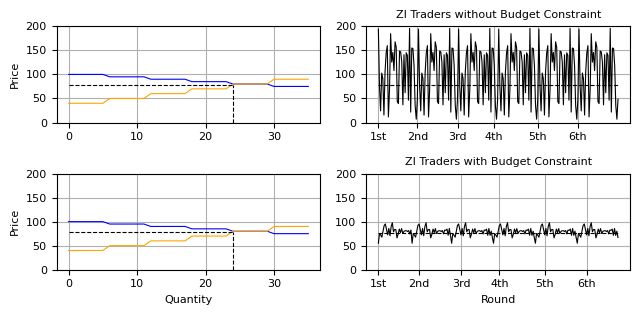

In [37]:
# replicate the first two rows of Figure 1
x0Price = [1*x for x in range(len(alltp_0))]
x1Price = [1*x for x in range(len(alltp_1))]
x = [1*x for x in range(numberTraders)]
fig, axs = plt.subplots(2, 2, figsize=(6.5, 3.25))

axs[0, 0].plot(x, buyerValues_0, 'blue',linewidth=0.8)
axs[0, 0].plot(x, sellerCosts_0, 'orange',linewidth=0.8)
axs[0, 0].plot([predictedQuantity, predictedQuantity], [0, predictedPrice], linestyle='--', color='black',linewidth=0.8)
axs[0, 0].plot([0, predictedQuantity], [predictedPrice, predictedPrice], linestyle='--', color='black',linewidth=0.8)
axs[0, 0].set_ylim(0, 200)
axs[0, 0].set_ylabel('Price',fontsize=8)
axs[0, 0].tick_params(axis='both', which='major', labelsize=8)
axs[0, 0].grid()

axs[0, 1].plot(x0Price, alltp_0, 'k',linewidth=0.8)
axs[0, 1].plot(x0Price, np.full_like(x0Price,predictedPrice), linestyle='--', color='black',linewidth=0.8)
axs[0, 1].set_ylim(0, 200)
axs[0, 1].set_xticks(ticks = [0,35,71,104,143,179], labels = ['1st', '2nd', '3rd', '4th', '5th', '6th'])
axs[0, 1].set_title('ZI Traders without Budget Constraint', fontsize=8)
axs[0, 1].tick_params(axis='both', which='major', labelsize=8)
axs[0, 1].grid()

axs[1, 0].plot(x, buyerValues_1, 'blue',linewidth=0.8)
axs[1, 0].plot(x, sellerCosts_1, 'orange',linewidth=0.8)
axs[1, 0].plot([predictedQuantity, predictedQuantity], [0, predictedPrice], linestyle='--', color='black',linewidth=0.8)
axs[1, 0].plot([0, predictedQuantity], [predictedPrice, predictedPrice], linestyle='--', color='black',linewidth=0.8)
axs[1, 0].set_ylim(0, 200)
axs[1, 0].set_xlabel('Quantity',fontsize=8)
axs[1, 0].set_ylabel('Price',fontsize=8)
axs[1, 0].tick_params(axis='both', which='major', labelsize=8)
axs[1, 0].grid()

axs[1, 1].plot(x1Price, alltp_1, 'k',linewidth=0.8)
axs[1, 1].plot(x1Price, np.full_like(x1Price,predictedPrice), linestyle='--', color='black',linewidth=0.8)
axs[1, 1].set_ylim(0, 200)
axs[1, 1].set_xticks(ticks = [0,35,71,104,143,179], labels = ['1st', '2nd', '3rd', '4th', '5th', '6th'])
axs[1, 1].set_title('ZI Traders with Budget Constraint', fontsize=8)
axs[1, 1].set_xlabel('Round',fontsize=8)
axs[1, 1].tick_params(axis='both', which='major', labelsize=8)
axs[1, 1].grid()

plt.tight_layout()
plt.savefig('The First Two Rows of Figure 1.png')
plt.show()

In [38]:
# Replicate the first two rows of Column 1 of Table 2 in Gode & Sunder (1993)
print('Results:')
print('The equilibrium quantity is '+str(predictedQuantity)+', and equilibrium quantity price is '+ str(predictedPrice)[0:5]) 
print('The efficiency of the ZI_U market is '+str(surplusPercentage_0)[0:5])
print('The efficiency of the ZI_C market is '+str(surplusPercentage_1)[0:5])

Results:
The equilibrium quantity is 24, and equilibrium quantity price is 77.5
The efficiency of the ZI_U market is 90.0
The efficiency of the ZI_C market is 98.61
900
